In [0]:
#Importing the required libraries 
%matplotlib inline
import numpy  as np  
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
import h5py
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from keras.datasets import mnist, fashion_mnist

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint, Callback

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model

from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Reshape, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, MaxPool2D, Convolution2D, UpSampling2D, Conv2DTranspose, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical,normalize

from keras import optimizers
from keras.optimizers import SGD, RMSprop, Adam, Nadam

import pickle
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
!nvidia-smi

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Wed Dec 11 01:13:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------

In [0]:
os.chdir("/content/drive/My Drive/MiniProject4")

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt
import pickle
import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losses = {"D_real":[], "D_fake":[] ,"G":[]}

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
            
            self.losses["D_real"].append(d_loss[0])
            self.losses["D_fake"].append(d_loss[1])
            self.losses["G"].append(g_loss)
            #with open('WGAN_RMS.pickle', 'wb') as handle:
              #pickle.dump(self.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
        self.plot_loss()

    def gan_test(self, model_file, num_examples):
        self.generator = self.build_generator()
        self.generator.load_weights(model_file)
        noise = np.random.normal(0, 1, (num_examples, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape)
        
        for i in range(num_examples):
            plt.imsave("./imgs/wgan/image"+str(i)+".png", gen_imgs[i, :, :, 0], cmap = "gray")

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/wgan_%d.png" % epoch)
        plt.close()

    def plot_loss(self):
        d_loss = [v for v in self.losses["D_real"]]
        g_loss = [v for v in self.losses["G"]]
        #d_acc = [v[1] for v in losses["D"]]
        #g_acc = [v[1] for v in losses["G"]]

        plt.figure(figsize=(10,8))
        plt.plot(d_loss, label="Discriminator loss")
        plt.plot(g_loss, label="Generator loss")
        #plt.plot(d_acc, label="Discriminator accuracy")
        #plt.plot(g_acc, label="Generator accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('WGAN RMS')
        plt.legend()
        plt.savefig("./WGAN_rms_loss.png")
        plt.show()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8, 8, 32)         

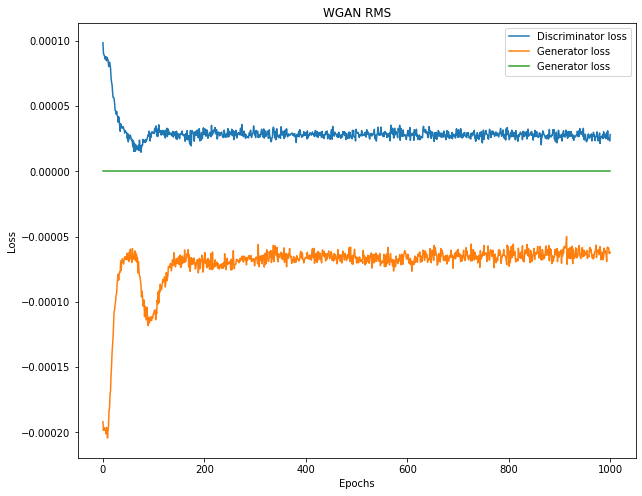

In [0]:
wgan = WGAN()
wgan.train(epochs=1001, batch_size = 64, sample_interval = 250)